In [22]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt
from CB_02704 import *
path = "../02704_data"

### LOAD IN ALL DATAFILES

1. geno files -> unphased genotype files with 0, 1, 2, or 9 for missing values
2. geno1 -> phased genotype file for haplotype 1, obtained from simulate_geno_pheno.ipynb by converting unphased to phased data
3. geno2 -> phased genotype file for haplotype 2, obtained in same fashion as geno1
4. ancs1 -> predicted local ancestry for snp i and individual j at haplotype 1, prediction done using flare software
5. ancs2 -> predicted local ancestry for snp i and individual j at haplotype 2, prediction done using flare software

In [23]:
ceu_geno = np.load("geno_files/ceu_geno.npy")
yri_geno = np.load("geno_files/yri_geno.npy")
asw_geno = np.load("geno_files/asw_geno.npy")
sim_geno = np.load("geno_files/sim_geno.npy")

ceu_geno = np.ma.masked_array(ceu_geno)
yri_geno = np.ma.masked_array(yri_geno)
asw_geno = np.ma.masked_array(asw_geno)
sim_geno = np.ma.masked_array(sim_geno)


ceu_snp = read_snp(f"{path}/ceu.snp")
ceu_snp = ceu_snp.drop_duplicates(subset="position", keep=False)


asw_geno1 = np.load("asw_geno1.npy")
asw_geno2 = np.load("asw_geno2.npy")
asw_ancs1 = np.load("asw_ancs1.npy")
asw_ancs2 = np.load("asw_ancs2.npy")
asw_snps = np.load("asw_snps.npy")


sim_geno1 = np.load("sim_geno1.npy")
sim_geno2 = np.load("sim_geno2.npy")
sim_ancs1 = np.load("sim_ancs1.npy")
sim_ancs2 = np.load("sim_ancs2.npy")
sim_snps = np.load("sim_snps.npy")

asw_geno1 = np.ma.masked_array(asw_geno1)
asw_geno2 = np.ma.masked_array(asw_geno2)

In [24]:
print(np.shape(asw_snps))
print(np.shape(asw_geno1))

(684252, 1)
(684252, 49)


In [25]:
asw_geno = np.zeros(np.shape(asw_geno1))
for i in range(len(asw_geno1)):
    print(i)
    for j in range(len(asw_geno1[i])):
        if asw_geno1[i,j] == 1 and asw_geno2[i,j] == 1:
            asw_geno[i,j] = 2
        elif asw_geno1[i,j] == 0 and asw_geno2[i,j] == 1:
            asw_geno[i,j] = 1
        elif asw_geno1[i,j] == 1 and asw_geno2[i,j] == 0:
            asw_geno[i,j] = 1
asw_geno = np.ma.masked_array(asw_geno)

### DISEASE SNPS

In [39]:
def simulate_effect_sizes(n_snps):
    effect_sizes = np.zeros((2, 10 * n_snps))
    disease_effect_sizes_pop1 = np.abs(np.random.randn(n_snps))
    disease_effect_sizes_pop2 = np.abs(np.random.randn(n_snps))
    effect_sizes[0, :n_snps] = disease_effect_sizes_pop1
    effect_sizes[1, :n_snps] = disease_effect_sizes_pop2
    return effect_sizes

def get_disease_snp_indices(disease_name):
    disease = pd.read_csv(f"{disease_name}.tsv", sep="\t")
    disease_snps = np.intersect1d(asw_snps, disease["SNPS"])

    disease_snp_indices = []
    for snp in disease_snps:
        
        index = np.where(asw_snps == snp)[0][0]
        disease_snp_indices.append(index)
    disease_snp_indices = sorted(disease_snp_indices)

    non_causal_snps = np.random.choice(len(asw_snps), 10 * len(disease_snp_indices) - len(disease_snp_indices), replace=False)
    non_causal_snps = sorted(non_causal_snps)
    for snp in non_causal_snps:
        disease_snp_indices.append(snp)
    effect_sizes = simulate_effect_sizes(len(disease_snps))
    return disease_snp_indices, non_causal_snps, effect_sizes
hypertension_disease_snp_indices, hypertension_non_causal_snps, hypertension_effect_sizes = get_disease_snp_indices("hypertension")
t1d_disease_snp_indices, t1d_non_causal_snps, t1d_effect_sizes = get_disease_snp_indices("t1d")

In [40]:
# compute_var
# input: array X
# output: variance of X
def compute_var(X):
    var = 0
    mean_X = np.mean(X)
    for i in X:
        var += ((i - mean_X) ** 2)
    var /= len(X)
    return var

# compute_cov
# input: arrays X and Y
# output: covariance of X and Y
def compute_cov(X, Y): 
    cov = 0
    mean_X = np.mean(X)
    mean_Y = np.mean(Y)
    for i, j in zip(X,Y):
        cov += (i - mean_X) * (j - mean_Y)
    cov /= len(X)
    return cov
    
# compute_r2
# input: snps dataframe, and boolean variable allow_monomorphic 
# output: array of r2 values representing the correlation between snp[i] and snp[i+1] where i is an index from 1...len(snps)-1
def compute_r2(snps):

    r2_array = []
    
    snp_indices = snps.index
    
    for i in snp_indices[:-1]: 
        snp1 = snps.iloc[snp_indices[i]] # subset specific snps
        snp2 = snps.iloc[snp_indices[i+1]]
    
        
        snp_cov = compute_cov(snp1, snp2)

        
        snp1_var = compute_var(snp1)
        snp2_var = compute_var(snp2)
        
        if snp1_var == 0 or snp2_var == 0:
            continue
        
        r2 = (snp_cov**2) / (snp1_var * snp2_var)
        r2_array.append(r2)
    
    return r2_array

In [41]:
def normalize(X):
    X = X.astype("float64")
    X[np.where(X == 9)] = 0
    p = X.mean(axis=1, keepdims=True).filled(-1) / 2
    X = (X - 2*p) / np.sqrt((2*p*(1-p)))
    return X

In [42]:
def normal_prs(geno_data, indices, num_causal, effect_sizes):
    X = normalize(geno_data[indices])
    
    simulated_phenotypes = np.dot(effect_sizes[0], X)
    N = np.shape(X)[1]
    atts = []
    p_vals = []
    for i, snp in enumerate(X):
        r2_df = pd.DataFrame({0: snp, 1: simulated_phenotypes})
        r2 = np.mean(compute_r2(r2_df.T))
        att = N * r2
        atts.append(att)
        p_vals.append(ss.chi2.sf(att,1))
    print(f"The average χ^2 for the causal SNPs is {np.mean(atts[:num_causal])}")   
    print(f"The average χ^2 for the null SNPs is {np.mean(atts[num_causal:])}")   
    print(f"The average χ^2 for all SNPs is {np.mean(atts)}")
    print()
    print(f"The expected average χ^2 value for the causal SNPs is {1 + ((1 * N) / num_causal)}")
    print(f"The expected average χ^2 value for the null SNPs is 1")
    print(f"The expected average χ^2 value for all SNPs is {1 + ((1 * N) / len(indices))}")
    return atts, p_vals

t1d_normal_asw_atts, t1d_normal_asw_p_vals = normal_prs(asw_geno, t1d_disease_snp_indices, len(t1d_disease_snp_indices) - len(t1d_non_causal_snps),  t1d_effect_sizes)
hypertension_normal_asw_atts, hypertension_normal_asw_p_vals = normal_prs(asw_geno, hypertension_disease_snp_indices, len(hypertension_disease_snp_indices) - len(hypertension_non_causal_snps),  hypertension_effect_sizes)

The average χ^2 for the causal SNPs is 1.8236944132848507
The average χ^2 for the null SNPs is 1.1599266649007263
The average χ^2 for all SNPs is 1.2263034397391388

The expected average χ^2 value for the causal SNPs is 1.2784090909090908
The expected average χ^2 value for the null SNPs is 1
The expected average χ^2 value for all SNPs is 1.027840909090909
The average χ^2 for the causal SNPs is 1.0205953744742862
The average χ^2 for the null SNPs is 0.9739901986995224
The average χ^2 for all SNPs is 0.9786507162769987

The expected average χ^2 value for the causal SNPs is 1.1454005934718101
The expected average χ^2 value for the null SNPs is 1
The expected average χ^2 value for all SNPs is 1.014540059347181


In [ ]:
def gaudi_prs(geno_data, geno_data1, geno_data2, anc_data1, anc_data2, indices, num_causal, effect_sizes):
    X = normalize(geno_data[indices])
    X1 = normalize(geno_data1[indices])
    X2 = normalize(geno_data2[indices])
    

    A1 = anc_data1[indices]
    A2 = anc_data2[indices]
    
    B1 = effect_sizes[0]
    B2 = effect_sizes[1]
    
    A1_pop1 = 1 - A1 # array is 1 if locus i is part of pop1 for individual j at haplotype 1
    A1_pop2 = A1  # array is 1 if locus is part of pop2 for individual j at haplotype 1
    A2_pop1 = 1 - A2
    A2_pop2 = A2
    

    term1 = X1 * A1_pop1
    term2 = X2 * A2_pop1
    
    term3 = X1 * A1_pop2
    term4 = X2 * A2_pop2
    
    
    sum_pop1 = term1 + term2
    sum_pop2 = term3 + term4
    
    
    simulated_phenotypes = np.dot(B1, sum_pop1) + np.dot(B2, sum_pop2)
    N = np.shape(X)[1]
    atts = []
    p_vals = []
    for i, snp in enumerate(X):

        r2_df = pd.DataFrame({0: snp, 1: simulated_phenotypes})
        r2 = np.mean(compute_r2(r2_df.T))
        att = N * r2
        atts.append(att)
        p_vals.append(ss.chi2.sf(att, 1))
    print(f"The average χ^2 for the causal SNPs is {np.mean(atts[:num_causal])}")   
    print(f"The average χ^2 for the null SNPs is {np.mean(atts[num_causal:])}")   
    print(f"The average χ^2 for all SNPs is {np.mean(atts)}")
    print()
    print(f"The expected average χ^2 value for the causal SNPs is {1 + ((1 * N) / num_causal)}")
    print(f"The expected average χ^2 value for the null SNPs is 1")
    print(f"The expected average χ^2 value for all SNPs is {1 + ((1 * N) / len(indices))}")
    return atts, p_vals

# np.save("hypertension_effect_sizes.npy", hypertension_effect_sizes)
# np.save("t1d_effect_sizes.npy", t1d_effect_sizes)
t1d_gaudi_asw_atts, t1d_gaudi_asw_p_vals = gaudi_prs(asw_geno, asw_geno1, asw_geno2, asw_ancs1, asw_ancs2, t1d_disease_snp_indices, len(t1d_disease_snp_indices) - len(t1d_non_causal_snps),  t1d_effect_sizes)
hypertension_gaudi_asw_atts, hypertension_gaudi_asw_p_vals = gaudi_prs(asw_geno, asw_geno1, asw_geno2, asw_ancs1, asw_ancs2, hypertension_disease_snp_indices, len(hypertension_disease_snp_indices) - len(hypertension_non_causal_snps),  hypertension_effect_sizes)



The average χ^2 for the causal SNPs is 1.0246126584745683
The average χ^2 for the null SNPs is 1.064018672026413
The average χ^2 for all SNPs is 1.0600780706712287

The expected average χ^2 value for the causal SNPs is 1.2784090909090908
The expected average χ^2 value for the null SNPs is 1
The expected average χ^2 value for all SNPs is 1.027840909090909
The average χ^2 for the causal SNPs is 1.0892541100606352
The average χ^2 for the null SNPs is 1.0739392575128917
The average χ^2 for all SNPs is 1.0754707427676662

The expected average χ^2 value for the causal SNPs is 1.1454005934718101
The expected average χ^2 value for the null SNPs is 1
The expected average χ^2 value for all SNPs is 1.014540059347181


: 

### TYPE 1 DIABETES GAUDI CHI 2 HISTOGRAM - ASW DATA

The observed average χ^2 for the type 1 diabetes causal SNPs is 1.0246126584745683
The observed average χ^2 for the type 1 diabetes null SNPs is 1.064018672026413
The observed average χ^2 for the type 1 diabetes all SNPs is 1.0600780706712287
The expected average χ^2 for the type 1 diabetes causal SNPs is 1.2784090909090908
The expected average χ^2 for the type 1 diabetes null SNPs is 1
The expected average χ^2 for the type 1 diabetes all SNPs is 1.027840909090909



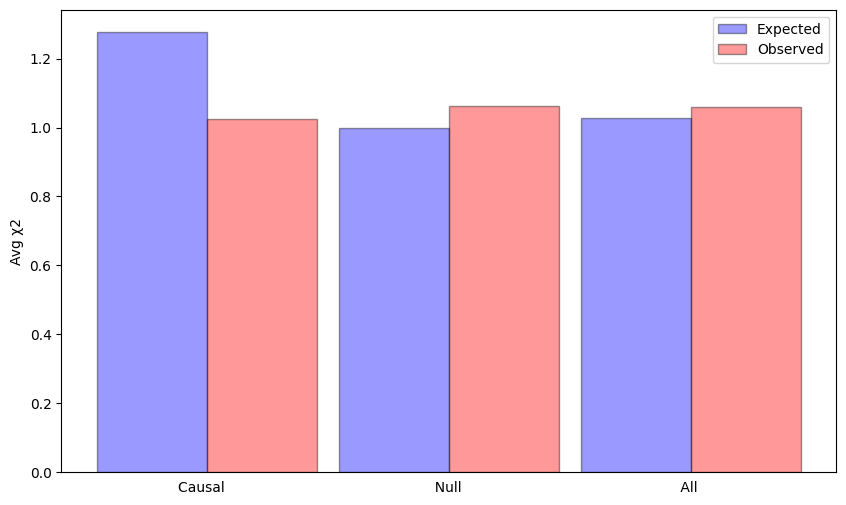

In [ ]:
N = np.shape(asw_geno)[1]

t1d_num_causal = len(t1d_disease_snp_indices) - len(t1d_non_causal_snps)
t1d_gaudi_asw_obs_att_causal = np.mean(t1d_gaudi_asw_atts[:t1d_num_causal])
t1d_gaudi_asw_obs_att_null = np.mean(t1d_gaudi_asw_atts[t1d_num_causal:])
t1d_gaudi_asw_obs_att_all = np.mean(t1d_gaudi_asw_atts)

t1d_gaudi_asw_exp_att_causal = 1 + ((1 * N) / t1d_num_causal)
t1d_gaudi_asw_exp_att_null = 1
t1d_gaudi_asw_exp_att_all = 1 + ((1 * N) / len(t1d_disease_snp_indices))

print(f"The observed average χ^2 for the type 1 diabetes causal SNPs is {t1d_gaudi_asw_obs_att_causal}")
print(f"The observed average χ^2 for the type 1 diabetes null SNPs is {t1d_gaudi_asw_obs_att_null}")
print(f"The observed average χ^2 for the type 1 diabetes all SNPs is {t1d_gaudi_asw_obs_att_all}")

print(f"The expected average χ^2 for the type 1 diabetes causal SNPs is {t1d_gaudi_asw_exp_att_causal}")
print(f"The expected average χ^2 for the type 1 diabetes null SNPs is {t1d_gaudi_asw_exp_att_null}")
print(f"The expected average χ^2 for the type 1 diabetes all SNPs is {t1d_gaudi_asw_exp_att_all}")
print()

# plotting barplot
fig, ax = plt.subplots(figsize=(10, 6))
ax.tick_params(
    bottom=False,
    labelbottom=False
)

x = np.arange(1)

y1 = [t1d_gaudi_asw_exp_att_causal]
y2 = [t1d_gaudi_asw_obs_att_causal]
y3 = [t1d_gaudi_asw_exp_att_null]
y4 = [t1d_gaudi_asw_obs_att_null]
y5 = [t1d_gaudi_asw_exp_att_all]
y6 = [t1d_gaudi_asw_obs_att_all]


ax.bar(x-2.75, y1, width=1.25, edgecolor='black', color="blue",alpha=0.4, label="Expected")
ax.bar(x-1.5, y2, width=1.25, edgecolor='black', color="red",alpha=0.4, label="Observed")
ax.bar(x, y3, width=1.25, edgecolor='black', color="blue",alpha=0.4)
ax.bar(x+1.25, y4, width=1.25, edgecolor='black', color="red",alpha=0.4)
ax.bar(x+2.75, y5, width=1.25, edgecolor='black', color="blue",alpha=0.4)
ax.bar(x+4, y6, width=1.25, edgecolor='black', color="red",alpha=0.4)

plt.legend()

ax.set_xlabel("Causal                                                Null                                                  All", loc="left")
ax.xaxis.set_label_coords(0.15, -0.02)
ax.set_ylabel("Avg χ2")
plt.show()
# plt.bar(x+0.1, y2, width)

### HYPERTENSION GAUDI CHI 2 HISTOGRAM - ASW DATA

The observed average χ^2 for the hypertension causal SNPs is 1.0892541100606352
The observed average χ^2 for the hypertension null SNPs is 1.0739392575128917
The observed average χ^2 for all hypertension the SNPs is 1.0754707427676662
The expected average χ^2 for the hypertension causal SNPs is 1.1454005934718101
The expected average χ^2 for the hypertension null SNPs is 1
The expected average χ^2 for all hypertension the SNPs is 1.014540059347181



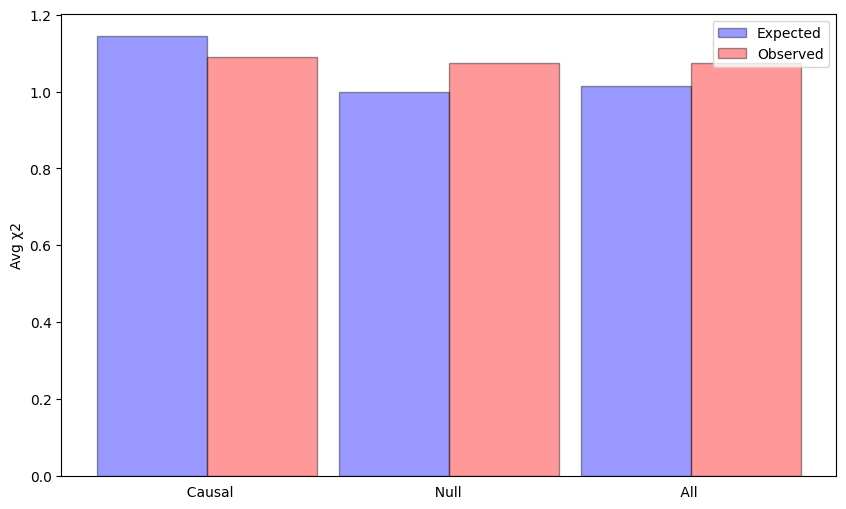

In [45]:
N = np.shape(asw_geno)[1]

hypertension_num_causal = len(hypertension_disease_snp_indices) - len(hypertension_non_causal_snps)
hypertension_gaudi_asw_obs_att_causal = np.mean(hypertension_gaudi_asw_atts[:hypertension_num_causal])
hypertension_gaudi_asw_obs_att_null = np.mean(hypertension_gaudi_asw_atts[hypertension_num_causal:])
hypertension_gaudi_asw_obs_att_all = np.mean(hypertension_gaudi_asw_atts)

hypertension_gaudi_asw_exp_att_causal = 1 + ((1 * N) / hypertension_num_causal)
hypertension_gaudi_asw_exp_att_null = 1
hypertension_gaudi_asw_exp_att_all = 1 + ((1 * N) / len(hypertension_disease_snp_indices))

print(f"The observed average χ^2 for the hypertension causal SNPs is {hypertension_gaudi_asw_obs_att_causal}")
print(f"The observed average χ^2 for the hypertension null SNPs is {hypertension_gaudi_asw_obs_att_null}")
print(f"The observed average χ^2 for all hypertension the SNPs is {hypertension_gaudi_asw_obs_att_all}")

print(f"The expected average χ^2 for the hypertension causal SNPs is {hypertension_gaudi_asw_exp_att_causal}")
print(f"The expected average χ^2 for the hypertension null SNPs is {hypertension_gaudi_asw_exp_att_null}")
print(f"The expected average χ^2 for all hypertension the SNPs is {hypertension_gaudi_asw_exp_att_all}")
print()


fig, ax = plt.subplots(figsize=(10, 6))
ax.tick_params(
    bottom=False,
    labelbottom=False
)

x = np.arange(1)

y1 = [hypertension_gaudi_asw_exp_att_causal]
y2 = [hypertension_gaudi_asw_obs_att_causal]
y3 = [hypertension_gaudi_asw_exp_att_null]
y4 = [hypertension_gaudi_asw_obs_att_null]
y5 = [hypertension_gaudi_asw_exp_att_all]
y6 = [hypertension_gaudi_asw_obs_att_all]

ax.bar(x-2.75, y1, width=1.25, edgecolor='black', color="blue",alpha=0.4, label="Expected")
ax.bar(x-1.5, y2, width=1.25, edgecolor='black', color="red",alpha=0.4, label="Observed")
ax.bar(x, y3, width=1.25, edgecolor='black', color="blue",alpha=0.4)
ax.bar(x+1.25, y4, width=1.25, edgecolor='black', color="red",alpha=0.4)
ax.bar(x+2.75, y5, width=1.25, edgecolor='black', color="blue",alpha=0.4)
ax.bar(x+4, y6, width=1.25, edgecolor='black', color="red",alpha=0.4)

ax.legend()

ax.set_xlabel("  Causal                                              Null                                                  All", loc="left")
ax.xaxis.set_label_coords(0.15, -0.02)
ax.set_ylabel("Avg χ2")
plt.show()

### TYPE 1 DIABETES NORMAL PRS CHI 2 HISTOGRAM - ASW

The observed average χ^2 for the type 1 diabetes causal SNPs is 1.8236944132848507
The observed average χ^2 for the type 1 diabetes null SNPs is 1.1599266649007263
The observed average χ^2 for the type 1 diabetes all SNPs is 1.2263034397391388
The expected average χ^2 for the type 1 diabetes causal SNPs is 1.2784090909090908
The expected average χ^2 for the type 1 diabetes null SNPs is 1
The expected average χ^2 for the type 1 diabetes all SNPs is 1.027840909090909



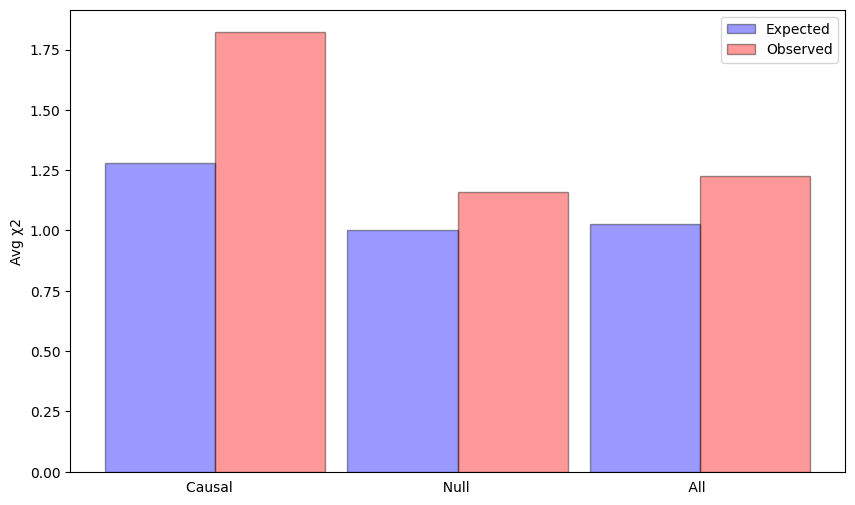

In [46]:
N = np.shape(asw_geno)[1]

t1d_num_causal = len(t1d_disease_snp_indices) - len(t1d_non_causal_snps)
t1d_normal_asw_obs_att_causal = np.mean(t1d_normal_asw_atts[:t1d_num_causal])
t1d_normal_asw_obs_att_null = np.mean(t1d_normal_asw_atts[t1d_num_causal:])
t1d_normal_asw_obs_att_all = np.mean(t1d_normal_asw_atts)

t1d_normal_asw_exp_att_causal = 1 + ((1 * N) / t1d_num_causal)
t1d_normal_asw_exp_att_null = 1
t1d_normal_asw_exp_att_all = 1 + ((1 * N) / len(t1d_disease_snp_indices))

print(f"The observed average χ^2 for the type 1 diabetes causal SNPs is {t1d_normal_asw_obs_att_causal}")
print(f"The observed average χ^2 for the type 1 diabetes null SNPs is {t1d_normal_asw_obs_att_null}")
print(f"The observed average χ^2 for the type 1 diabetes all SNPs is {t1d_normal_asw_obs_att_all}")

print(f"The expected average χ^2 for the type 1 diabetes causal SNPs is {t1d_normal_asw_exp_att_causal}")
print(f"The expected average χ^2 for the type 1 diabetes null SNPs is {t1d_normal_asw_exp_att_null}")
print(f"The expected average χ^2 for the type 1 diabetes all SNPs is {t1d_normal_asw_exp_att_all}")
print()

# plotting barplot
fig, ax = plt.subplots(figsize=(10, 6))
ax.tick_params(
    bottom=False,
    labelbottom=False
)

x = np.arange(1)

y1 = [t1d_normal_asw_exp_att_causal]
y2 = [t1d_normal_asw_obs_att_causal]
y3 = [t1d_normal_asw_exp_att_null]
y4 = [t1d_normal_asw_obs_att_null]
y5 = [t1d_normal_asw_exp_att_all]
y6 = [t1d_normal_asw_obs_att_all]


ax.bar(x-2.75, y1, width=1.25, edgecolor='black', color="blue",alpha=0.4, label="Expected")
ax.bar(x-1.5, y2, width=1.25, edgecolor='black', color="red",alpha=0.4, label="Observed")
ax.bar(x, y3, width=1.25, edgecolor='black', color="blue",alpha=0.4)
ax.bar(x+1.25, y4, width=1.25, edgecolor='black', color="red",alpha=0.4)
ax.bar(x+2.75, y5, width=1.25, edgecolor='black', color="blue",alpha=0.4)
ax.bar(x+4, y6, width=1.25, edgecolor='black', color="red",alpha=0.4)

plt.legend()

ax.set_xlabel("Causal                                                Null                                                  All", loc="left")
ax.xaxis.set_label_coords(0.15, -0.02)
ax.set_ylabel("Avg χ2")
plt.show()
# plt.bar(x+0.1, y2, width)

### HYPERTENSION NORMAL PRS CHI 2 HISTOGRAM - ASW

The observed average χ^2 for the type 1 diabetes causal SNPs is 1.0205953744742862
The observed average χ^2 for the type 1 diabetes null SNPs is 0.9739901986995224
The observed average χ^2 for the type 1 diabetes all SNPs is 0.9786507162769987
The expected average χ^2 for the type 1 diabetes causal SNPs is 1.1454005934718101
The expected average χ^2 for the type 1 diabetes null SNPs is 1
The expected average χ^2 for the type 1 diabetes all SNPs is 1.014540059347181



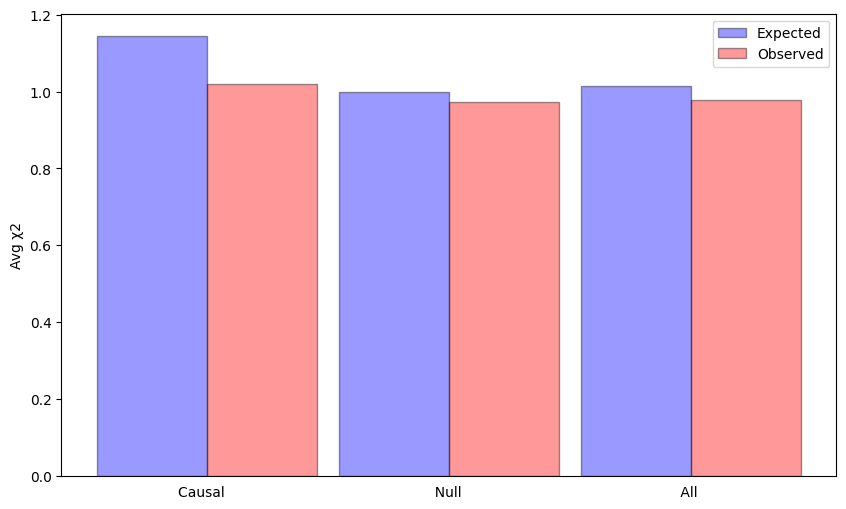

In [47]:
N = np.shape(asw_geno)[1]

hypertension_num_causal = len(hypertension_disease_snp_indices) - len(hypertension_non_causal_snps)
hypertension_normal_asw_obs_att_causal = np.mean(hypertension_normal_asw_atts[:hypertension_num_causal])
hypertension_normal_asw_obs_att_null = np.mean(hypertension_normal_asw_atts[hypertension_num_causal:])
hypertension_normal_asw_obs_att_all = np.mean(hypertension_normal_asw_atts)

hypertension_normal_asw_exp_att_causal = 1 + ((1 * N) / hypertension_num_causal)
hypertension_normal_asw_exp_att_null = 1
hypertension_normal_asw_exp_att_all = 1 + ((1 * N) / len(hypertension_disease_snp_indices))

print(f"The observed average χ^2 for the type 1 diabetes causal SNPs is {hypertension_normal_asw_obs_att_causal}")
print(f"The observed average χ^2 for the type 1 diabetes null SNPs is {hypertension_normal_asw_obs_att_null}")
print(f"The observed average χ^2 for the type 1 diabetes all SNPs is {hypertension_normal_asw_obs_att_all}")

print(f"The expected average χ^2 for the type 1 diabetes causal SNPs is {hypertension_normal_asw_exp_att_causal}")
print(f"The expected average χ^2 for the type 1 diabetes null SNPs is {hypertension_normal_asw_exp_att_null}")
print(f"The expected average χ^2 for the type 1 diabetes all SNPs is {hypertension_normal_asw_exp_att_all}")
print()

# plotting barplot
fig, ax = plt.subplots(figsize=(10, 6))
ax.tick_params(
    bottom=False,
    labelbottom=False
)

x = np.arange(1)

y1 = [hypertension_normal_asw_exp_att_causal]
y2 = [hypertension_normal_asw_obs_att_causal]
y3 = [hypertension_normal_asw_exp_att_null]
y4 = [hypertension_normal_asw_obs_att_null]
y5 = [hypertension_normal_asw_exp_att_all]
y6 = [hypertension_normal_asw_obs_att_all]


ax.bar(x-2.75, y1, width=1.25, edgecolor='black', color="blue",alpha=0.4, label="Expected")
ax.bar(x-1.5, y2, width=1.25, edgecolor='black', color="red",alpha=0.4, label="Observed")
ax.bar(x, y3, width=1.25, edgecolor='black', color="blue",alpha=0.4)
ax.bar(x+1.25, y4, width=1.25, edgecolor='black', color="red",alpha=0.4)
ax.bar(x+2.75, y5, width=1.25, edgecolor='black', color="blue",alpha=0.4)
ax.bar(x+4, y6, width=1.25, edgecolor='black', color="red",alpha=0.4)

plt.legend()

ax.set_xlabel("Causal                                                Null                                                  All", loc="left")
ax.xaxis.set_label_coords(0.15, -0.02)
ax.set_ylabel("Avg χ2")
plt.show()
# plt.bar(x+0.1, y2, width)